In [1]:
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
mem=Memory("./mycache")

@mem.cache
def get_training_data():
    data=load_svmlight_file("D:\Ipython_data\A9a.txt")
    return data[0],data[1]
x_train,y_train=get_training_data()
def get_testing_data():
    data=load_svmlight_file("D:\Ipython_data\A9at.txt")
    return data[0],data[1]
x_test,y_test=get_testing_data()

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class LogisticRegression(object):
    def __init__(self,Learning_rate=0.001,epoch=6):
        self.Learning_rate=Learning_rate
        self.epoch=epoch
        self.threshold=0.5
        self.y=0.9
        
    def fit_NAG(self,x,Y):
        self.w=np.zeros((1,x.shape[1]))
        self.cost_list=[]
        self.v=np.zeros((1,x.shape[1]))
        for i in range(self.epoch):
            cost=0
            for j in range(x.shape[0]):
                output=self.Logistic_input(x[j,:],self.threshold)
                if(output!=Y[j]):
                    t=-Y[j]*(x[j,:])
                    dwv=self.w-self.y*self.v
                    t=t.T.dot(dwv)
                    t=t.sum()
                    dv=self.w-(Y[j]*(x[j,:]))/(1+np.exp(t))
                    self.v*=self.y
                    self.v+=self.Learning_rate*dv
                    self.w=self.w-self.v
                    cost+=np.log(1+np.exp((-Y[j]*x[j,:].T.dot(self.w)).sum()))
            cost=cost/x.shape[0]+(self.w**2).sum()/2
            self.cost_list.append(cost)
        #print('self.cost_list:',self.cost_list)
        return self
    
    def fit_Rms(self,x,Y):
        self.e=10**(-8)
        self.cost_list=[]
        self.w=np.zeros((1,x.shape[1]))
        for i in range(self.epoch):
            cost=0
            for j in range(x.shape[0]):
                output=self.Logistic_input(x[j,:],self.threshold)
                if(output!=Y[j]):
                    #计算梯度gt
                    t=Y[j]*(x[j,:])
                    h=self.Logistic_input(t,self.threshold)
                    g=self.w-t*h
                   
                    #计算E[g^2]t
                    g1=g.T
                    E=g*g1
                    E=E.sum()
                    
                    #计算RMS[g]t
                    RMSgt=np.sqrt(self.e+E)
            
                    #计算dw
                    dw=(-self.Learning_rate/RMSgt)*g
                    
                    #更新w
                    self.w=self.w+dw
                    
                    #计算cost
                    cost+=np.log(1+np.exp((-Y[j]*x[j,:].T.dot(self.w)).sum()))
            self.w1=self.w.T
            cost=cost/x.shape[0]+(self.w*self.w1).sum()/2
            self.cost_list.append(cost)
        return self
    
    def fit_Adadelta(self,x,Y):
        self.e=10**(-8)
        self.cost_list=[]
        self.w=np.zeros((1,x.shape[1]))
        self.v=np.zeros((1,x.shape[1]))
        for i in range(self.epoch):
            cost=0
            for j in range(x.shape[0]):
                output=self.Logistic_input(x[j,:],self.threshold)
                if(output!=Y[i]):
                    #计算梯度gt
                    t=Y[j]*(x[j,:])
                    h=self.Logistic_input(t,self.threshold)
                    g=self.w-t*h
               
                    #计算E[g^2]t
                    g1=g.T
                    E=g*g1
                    E=E.sum()
                    #print('E:',E)
                    #E=np.mean(E)
                    
                    #计算RMS[g]t
                    RMSgt=np.sqrt(self.e+E)
                    
                    #计算dθt,保留学习率
                    dw=(-self.Learning_rate/RMSgt)*g
                    
                    #计算E[dw^2]t-1
                    dw1=dw.T
                    Edwt=dw*dw1
                    Edwt=Edwt.sum()
                    #Edwt=np.mean(Edwt)
                    
                    #计算RMS[dw]t-1
                    RMSwt1=np.sqrt(Edwt+self.e)
                    
                    #计算dθt，去掉学习率
                    
                    dwt=-(RMSwt1/RMSgt)*g
                    
                    #计算E[dw^2]t,dw1是dw转致
                    dw1=dw.T
                    Edwt=self.y*Edwt+(1-self.y)*((dw*dw1).sum())
                    
                    #Wt+1=Wt+dWt，更新w
                    #print(self.w.shape)
                    #print('dwt.shape:',dwt.shape)
                    self.w=self.w+dwt
                    #print('self.w.shape:',self.w.shape)
                    #print('self.x[j,:].shape:',x[j,:].shape)
                    
                    #计算cost
                    cost+=np.log(1+np.exp((-Y[j]*x[j,:].T.dot(self.w)).sum()))
                    #print(cost)
            self.w1=self.w.T
            cost=cost/x.shape[0]+(self.w*self.w1).sum()/2
            self.cost_list.append(cost)
        return self
        
    def fit_Adam(self,x,Y):
        self.e=10**(-8)
        self.cost_list=[]
        self.w=np.zeros((1,x.shape[1]))
        self.m=np.zeros((1,x.shape[1]))
        self.v=0
        self.p1=0.900
        self.p2=0.999
        for i in range(self.epoch):
            cost=0
            for j in range(x.shape[1]):
                output=self.Logistic_input(x[j,:],self.threshold)
                if(output!=Y[i]):
                    #计算梯度gt
                    t=Y[j]*(x[j,:])
                    h=self.Logistic_input(t,self.threshold)
                    g=self.w-t*h
                    
                    #计算m
                    self.m=self.m*self.p1+(1-self.p1)*g
                    
                    #计算m的修正误差M
                    M=self.m/(1-(self.p1**(j+1)))
                    
                    #计算v
                    g1=g.T
                    G=(g1*g).sum()
                    self.v=self.v*self.p2+(1-self.p2)*G
                    
                    #计算V
                    V=self.v/(1-(self.p2**(j+1)))
                    
                    #计算cost
                    cost+=np.log(1+np.exp((-Y[j]*x[j,:].T.dot(self.w)).sum()))
                    
                    #计算W
                    self.w=self.w-(self.Learning_rate/(np.sqrt(V)+self.e))*M
            self.w1=self.w.T
            cost=cost/x.shape[0]+(self.w*self.w1).sum()/2
            self.cost_list.append(cost)
        return self
    
    def Logistic_input(self,x,threshold):
        t=x.T.dot(self.w)
        t=t.sum()
        h=1/(1+np.exp(t))
        if(h<self.threshold):
            return -1
        else:
            return 1

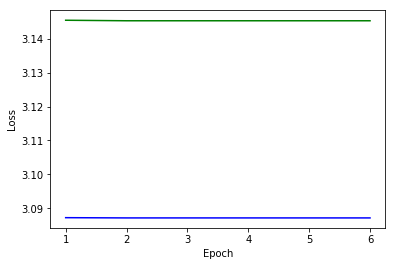

In [4]:
modela=LogisticRegression()
modela.fit_NAG(x_train,y_train)
modelb=LogisticRegression()
modelb.fit_NAG(x_test,y_test)

plt.plot(range(1,modela.epoch+1),modela.cost_list,'b-',range(1,modelb.epoch+1),modelb.cost_list,'g-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

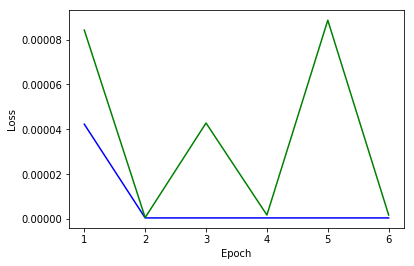

In [5]:
modelc=LogisticRegression()
modelc.fit_Adadelta(x_train,y_train)
modeld=LogisticRegression()
modeld.fit_Adadelta(x_test,y_test)
plt.plot(range(1,modelc.epoch+1),modelc.cost_list,'b-',range(1,modeld.epoch+1),modeld.cost_list,'g-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

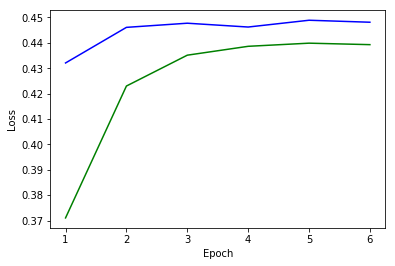

In [6]:
modele=LogisticRegression()
modele.fit_Rms(x_train,y_train)
modelf=LogisticRegression()
modelf.fit_Rms(x_test,y_test)
plt.plot(range(1,modele.epoch+1),modele.cost_list,'b-',range(1,modelf.epoch+1),modelf.cost_list,'g-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

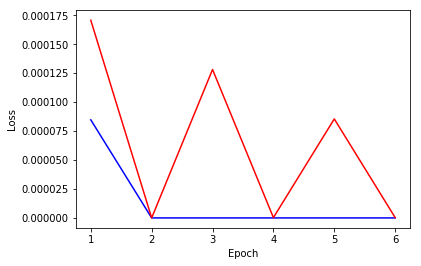

In [7]:
modelg=LogisticRegression()
modelg.fit_Adam(x_train,y_train)
modelh=LogisticRegression()
modelh.fit_Adam(x_test,y_test)
plt.plot(range(1,modelg.epoch+1),modelg.cost_list,'b-',range(1,modelh.epoch+1),modelh.cost_list,'r-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()